In [1]:
!git clone https://github.com/Decoding-Data-Science/fer-may-hackathon.git

Cloning into 'fer-may-hackathon'...
remote: Enumerating objects: 7139, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 7139 (delta 1), reused 22 (delta 0), pack-reused 7113
Receiving objects: 100% (7139/7139), 11.10 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Load the VGG16 model, excluding the top (final) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/fer-may-hackathon/images/train',
    target_size=(48, 48),
    color_mode='rgb',  # Using 'rgb' because VGG16 expects 3-channel input
    class_mode='categorical',
    batch_size=64
)

validation_generator = val_datagen.flow_from_directory(
    '/content/fer-may-hackathon/images/validation',
    target_size=(48, 48),
    color_mode='rgb',  # Using 'rgb' because VGG16 expects 3-channel input
    class_mode='categorical',
    batch_size=64
)

# Training the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)


58889256/58889256 [==============================] - 0s 0us/step
Found 7178 images belonging to 7 classes.
Found 3668 images belonging to 7 classes.
Epoch 1/50
113/113 [==============================] - 21s 122ms/step - loss: 2.2713 - accuracy: 0.2338 - val_loss: 1.7521 - val_accuracy: 0.3073 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - 12s 109ms/step - loss: 1.9582 - accuracy: 0.2678 - val_loss: 1.6628 - val_accuracy: 0.3402 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - 12s 106ms/step - loss: 1.8362 - accuracy: 0.2859 - val_loss: 1.5817 - val_accuracy: 0.3784 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - 12s 105ms/step - loss: 1.7575 - accuracy: 0.3043 - val_loss: 1.6085 - val_accuracy: 0.3593 - lr: 0.0010
Epoch 5/50
113/113 [==============================] - 12s 108ms/step - loss: 1.7284 - accuracy: 0.3129 - val_loss: 1.5760 - val_accuracy: 0.3798 - lr: 0.0010
Epoch 6/50
113/113 [==============================] - 12s 107

**Unfeezing the base model and training**

In [4]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
113/113 [==============================] - 22s 126ms/step - loss: 1.6067 - accuracy: 0.3644 - val_loss: 1.4773 - val_accuracy: 0.4381 - lr: 1.0000e-05
Epoch 2/50
113/113 [==============================] - 13s 116ms/step - loss: 1.5535 - accuracy: 0.3873 - val_loss: 1.3850 - val_accuracy: 0.4804 - lr: 1.0000e-05
Epoch 3/50
113/113 [==============================] - 13s 117ms/step - loss: 1.4934 - accuracy: 0.4244 - val_loss: 1.3247 - val_accuracy: 0.4902 - lr: 1.0000e-05
Epoch 4/50
113/113 [==============================] - 13s 117ms/step - loss: 1.4564 - accuracy: 0.4416 - val_loss: 1.2575 - val_accuracy: 0.5297 - lr: 1.0000e-05
Epoch 5/50
113/113 [==============================] - 13s 117ms/step - loss: 1.4099 - accuracy: 0.4603 - val_loss: 1.2445 - val_accuracy: 0.5374 - lr: 1.0000e-05
Epoch 6/50
113/113 [==============================] - 14s 127ms/step - loss: 1.3798 - accuracy: 0.4739 - val_loss: 1.2429 - val_accuracy: 0.5240 - lr: 1.0000e-05
Epoch 7/50
113/113 [========

**Validation Accuracy**

In [5]:
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // 64)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

57/57 [==============================] - 2s 26ms/step - loss: 0.6250 - accuracy: 0.7928
Validation Accuracy: 79.28%


**Train Accuracy**

In [14]:
loss, accuracy = model.evaluate(train_generator, steps=train_generator.samples // 64)
print(f'Train Accuracy: {accuracy*100:.2f}%')

112/112 [==============================] - 11s 101ms/step - loss: 0.7655 - accuracy: 0.7373
Train Accuracy: 73.73%


**Train and Validation Graph**

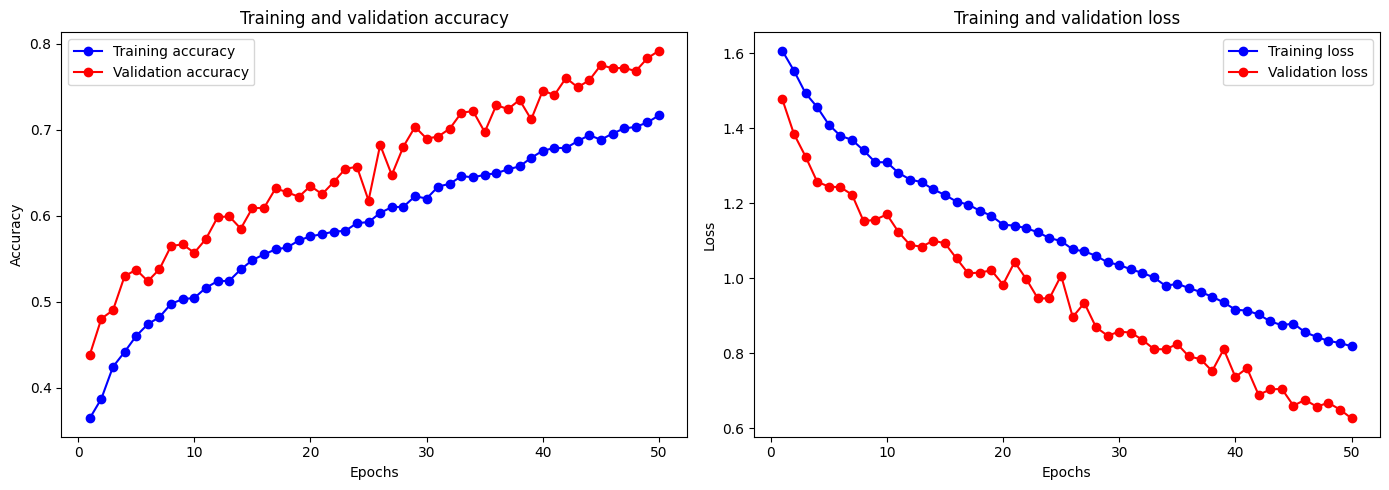

In [10]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Saving the model**

In [13]:
model.save('emotionmodel.h5')

In [17]:
import tensorflow as tf

# Load the pre-trained Keras model
model = tf.keras.models.load_model('emotionmodel.h5')

# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('emotion_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

